# Imports

In [22]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import matplotlib.pyplot as plt

# Dataset and Setup

In [23]:
#Loading the dataset
data = load_digits()
x = data.data # Contains the image that contains the digit
y = data.target #the value of the digit

# split dataset 70% train, 30% test/validation
X_train, X_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.30, stratify=y, random_state=42
)

# split 15% validation / 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42 #Stratify to equalize the splits
)

# Standardizing the data
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)


# Building the Model

In [24]:
def fit_gaussian_classifier(X, y, lam):
    # Multivariate Gaussian Distribution
    X = np.array(X)
    y = np.array(y)
    N, D = X.shape # N -> no of samples , D -> no of features 
    classes = np.unique(y) # identifying all possible classes

    # Calculate the prior P(y=c)
    priors = {}
    for c in classes:
        priors[c] = np.sum(y == c) / N 

    # Mean
    means = {}
    for c in classes:
        means[c] = X[y == c].mean(axis=0) # calc mean across all samples for each feature

    # shared covariance matrix
    means_matrix = np.zeros((N, D))
    for c in classes:
        means_matrix[y == c] = means[c]

    # (X - mean)
    X_centered = X - means_matrix   

    # 3) Covariance = (X_centered^T * X_centered) / N
    Sigma = (X_centered.T @ X_centered) / N

    # Regularization (Sigma + lambdaI)
    Sigma_reg = Sigma + lam * np.eye(D)
    Sigma_inv = np.linalg.inv(Sigma_reg)

    return priors, means, Sigma, Sigma_reg, Sigma_inv


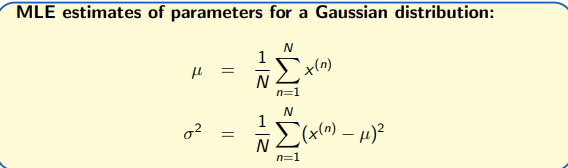

### Gaussian Generative Classifier (Multivariate Gaussian)

Implementation of **Gaussian generative classifier** for the digits dataset.  

- Each class has a prior probability `priors[c]`, calculated as the fraction of training samples in that class.  
- Features of each class follow a **multivariate Gaussian**: `p(x | y=c) ~ N(means[c], Sigma)`  
  - `means[c]` is the mean vector of class `c` (average of all training samples in that class)  
  - `Sigma` is the shared covariance matrix across all classes

**We regularize the covariance matrix by adding λI to Σ in order to make the matrix numerically stable and invertible**

What we calculate in this function:

1. **priors** → stored in `priors`  
2. **class means** → stored in `means`  
3. **shared covariance** → stored in `Sigma`  
4. **regularized covariance** → `Sigma_reg = Sigma + lam * I`  
5. **inverse of regularized covariance** → `Sigma_inv`  

These variables (`priors`, `means`, `Sigma`, `Sigma_reg`, `Sigma_inv`) will be used later in the **prediction step** to classify new samples.


In [25]:
def predict_gaussian(X, priors, means, Sigma_inv, Sigma_reg):
    X = np.array(X)
    N, D = X.shape
    classes = list(priors.keys())

    # compute log|Sigma|
    sign, logdet = np.linalg.slogdet(Sigma_reg)

    preds = []
    for i in range(N):
        x = X[i]
        best_class = None
        best_score = -1e18

        for c in classes:
            diff = x - means[c]
            quad = diff.T @ Sigma_inv @ diff   # (x - μ_k)^T Σ^-1 (x - μ_k)

            # full Gaussian log-likelihood 
            log_gauss = -0.5 * (D * np.log(2*np.pi) + logdet + quad)

            log_prior = np.log(priors[c])
            score = log_prior + log_gauss

            if score > best_score:
                best_score = score
                best_class = c

        preds.append(best_class)

    return np.array(preds)


In [26]:
lambdas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]

val_results = []

for lam in lambdas:
    priors, means, Sigma, Sigma_reg, Sigma_inv = fit_gaussian_classifier(X_train_s, y_train, lam)
    y_val_pred = predict_gaussian(X_val_s, priors, means, Sigma_inv, Sigma_reg)
    acc = accuracy_score(y_val, y_val_pred)
    val_results.append(acc)
    print("lambda =", lam, " => val acc =", acc)
    
best_lambda = lambda_list[np.argmax(val_results)]
print("BEST LAMBDA =", best_lambda)


lambda = 1e-06  => val acc = 0.9444444444444444
lambda = 1e-05  => val acc = 0.9444444444444444
lambda = 0.0001  => val acc = 0.9444444444444444
lambda = 0.001  => val acc = 0.9444444444444444
lambda = 0.01  => val acc = 0.9444444444444444
lambda = 0.1  => val acc = 0.9444444444444444
lambda = 1.0  => val acc = 0.9222222222222223
BEST LAMBDA = 0.0001


#### We tune the regularization parameter λ by searching over a list of candidate values.
For each λ, we train the Gaussian classifier on the training set, compute predictions on the validation set, and record the accuracy.
The λ value that achieves the highest validation accuracy is selected as the optimal regularization strength.
This prevents overfitting and ensures stable covariance estimation in high-dimensional data.

In [27]:
acc = accuracy_score(y_test, y_test_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_test_pred, average="macro")

print("Test Accuracy =", acc)
print("Macro Precision =", prec)
print("Macro Recall =", rec)
print("Macro F1 =", f1)


Test Accuracy = 0.9629629629629629
Macro Precision = 0.9631904761904762
Macro Recall = 0.9626577126577127
Macro F1 = 0.9624803472389681


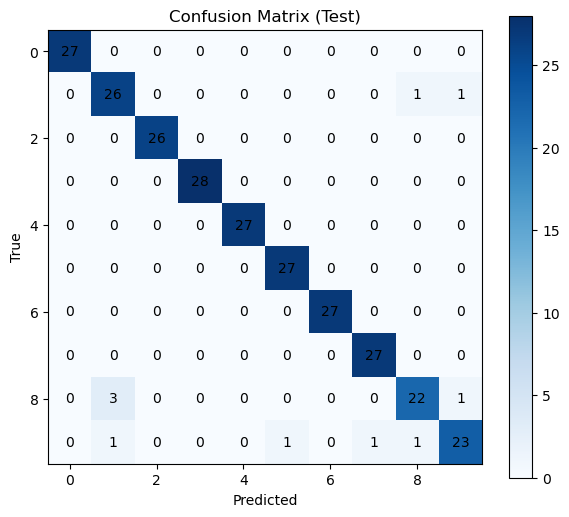

In [28]:
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(7,6))
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")

# write numbers on matrix
for i in range(len(cm)):
    for j in range(len(cm)):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.show()


## Discussion

After training the model and evaluating it, we find from the confusion matrix that the Gaussian generative classifier performs very well on this dataset. Digits from 0 to 7 are almost perfectly predicted. **The only early issue appears with the digit 1, which has two misclassifications where it was predicted as 8 and 9.** After that, the model seems a little confused around the**digit 8, with four mispredictions, and also around the digit 9, with three mispredictions.**  This makes sense because the digits are handwritten, and some 8s and 9s can look fairly similar depending on how they were written, which causes the model to mix them up.

The choice of λ (lambda) also had a noticeable effect. Smaller λ values made the covariance matrix unstable, while larger values smoothed things too much. The best λ gave a good balance, helping the model generalize better without losing important class-specific information. Overall, the Gaussian generative model shows strong performance, but its main weaknesses appear in digits that share similar shapes or writing styles, which is expected in handwritten digit datasets.